# TODO

* [x] предварительная обработка (очистка, лемматизация, удаление стоп-слов)
* [x] выделение тем (topic modeling)
* [x] выделение тем c ассоциированными новостями (topic modeling)
* [x] выделение смысловой выжимки (text summarization) ???
* [x] кластеризация
* [x] выделение населённых пунктов

In [3]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()

In [70]:
!pip install clean-text
!pip install nltk
!pip install spacy

     --------------------------------------- 11.9/11.9 MB 27.3 MB/s eta 0:00:00
     ---------------------------------------- 1.3/1.3 MB 40.4 MB/s eta 0:00:00
     ---------------------------------------- 94.7/94.7 kB 5.3 MB/s eta 0:00:00
     ------------------------------------- 479.4/479.4 kB 29.3 MB/s eta 0:00:00
  Using cached typer-0.7.0-py3-none-any.whl (38 kB)
     ---------------------------------------- 2.1/2.1 MB 43.9 MB/s eta 0:00:00
     ---------------------------------------- 48.9/48.9 kB ? eta 0:00:00
  Using cached spacy_legacy-3.0.10-py2.py3-none-any.whl (21 kB)
  Using cached wasabi-0.10.1-py3-none-any.whl (26 kB)
  Using cached langcodes-3.3.0-py3-none-any.whl (181 kB)
  Using cached smart_open-6.2.0-py3-none-any.whl (58 kB)
     ---------------------------------------- 7.0/7.0 MB 26.4 MB/s eta 0:00:00
  Using cached confection-0.0.3-py3-none-any.whl (32 kB)


In [73]:
!python -m spacy download ru_core_news_sm
!python -m spacy download ru_core_news_md
!python -m spacy download ru_core_news_lg

     --------------------------------------- 15.3/15.3 MB 14.2 MB/s eta 0:00:00
  Using cached pymorphy2-0.9.1-py3-none-any.whl (55 kB)
  Using cached DAWG_Python-0.7.2-py2.py3-none-any.whl (11 kB)
  Using cached pymorphy2_dicts_ru-2.4.417127.4579844-py2.py3-none-any.whl (8.2 MB)
  Using cached docopt-0.6.2.tar.gz (25 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13775 sha256=bc923351b6742d42f0d19251c4e7d1f8376c5b89fa2a0004621a019e6f5ae201
  Stored in directory: c:\users\1pc\appdata\local\pip\cache\wheels\7c\d7\8d\2156234738063e3d4a39ba77dc677046100e62766b53807189
Successfully built docopt
[+] Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
     ----------------------------------     466.6/513.4 MB 3.0 MB/s eta 0:00:16


ERROR: Wheel 'ru-core-news-lg' located at C:\Users\1PC\AppData\Local\Temp\pip-unpack-hp55a1wj\ru_core_news_lg-3.4.0-py3-none-any.whl is invalid.


# Объединение и очистка

In [57]:
df_test = pd.read_csv("../text_data/Colonelcassad.csv")
df_test.head(5)

,Unnamed: 0,url,text,photo_url,date
0,0,https://t.me/boris_rozhin,🇷🇺🇺🇦 259-й день спецоперации ВС РФ отметился п...,NaN,2022-11-10T00:04:40
1,1,https://t.me/boris_rozhin,9 ноября — хроника главных событий этого дня.\n\n,NaN,2022-11-10T02:16:01
2,2,https://t.me/boris_rozhin,"🇷🇺🇺🇦 Как мы и догадывались, прошедшей ночью в ...",NaN,2022-11-10T03:10:09
3,3,https://t.me/boris_rozhin,"Как сообщила газета «Ведомости», 5 ноября 2022...",NaN,2022-11-10T04:03:01
4,4,https://t.me/boris_rozhin,"Видео от подписчика. Работа САУ ""Гиацинт-С"". З...",NaN,2022-11-10T05:06:02


In [58]:
news_tables = [
    "../text_data/Colonelcassad.csv",
    "../text_data/Fighterbomber.csv",
    "../text_data/Helicopterpilot.csv",
    "../text_data/Kotsnews.csv",
    "../text_data/WarGonzo.csv",
    "../text_data/operation.csv",
    # "../text_data/news.csv",
]
dfs = []
for file in news_tables:
    dfs.append(pd.read_csv(file))
df = pd.concat(dfs, axis=0, ignore_index=True)

In [59]:
df.tail(5)
# df.iloc[:, 1]

,Unnamed: 0,url,text,photo_url,date
2296,210,https://t.me/RVvoenkor,NaN,NaN,2022-12-10T00:02:55
2297,211,https://t.me/RVvoenkor,NaN,NaN,2022-12-10T13:29:12
2298,212,https://t.me/RVvoenkor,"Бои на окраинах Артемовска. Видно, что идет об...",NaN,2022-12-10T16:19:15
2299,213,https://t.me/RVvoenkor,🔞\n,NaN,2022-12-10T18:27:12
2300,214,https://t.me/RVvoenkor,NaN,NaN,2022-12-10T21:04:30


In [60]:
from cleantext import clean
from cleantext.sklearn import CleanTransformer

In [61]:
def clean1(x):
    result = clean(x,
        fix_unicode=True,               # fix various unicode errors
        to_ascii=False,                  # transliterate to closest ASCII representation
        lower=True,                     # lowercase text
        no_line_breaks=True,           # fully strip line breaks as opposed to only normalizing them
        no_urls=True,                  # replace all URLs with a special token
        no_emails=True,                # replace all email addresses with a special token
        no_phone_numbers=False,         # replace all phone numbers with a special token
        no_numbers=False,               # replace all numbers with a special token
        no_digits=False,                # replace all digits with a special token
        no_currency_symbols=False,      # replace all currency symbols with a special token
        no_punct=False,                 # remove punctuations
        replace_with_punct="",          # instead of removing punctuations you may replace them
        replace_with_url="",
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_digit="",
        replace_with_currency_symbol="",
        lang="ru"                       # set to 'de' for German special handling
    )
    return result

# for idx, df_item in tqdm(enumerate(dfs)):
#     df_item["text_clean"] = df_item["text"].apply(lambda x: clean1(x))
#     df_item["title_clean"] = df_item["title"].apply(lambda x: clean1(x))
#     df_item = df_item.dropna(subset=['title', 'text','title_clean','text_clean'])
#     df_item.to_csv(f"df{idx}_cleaned.csv")\
df = df.iloc[:,1:]
df["text_clean"] = df["text"].apply(lambda x: clean1(x))  # столбик очищенного текста
df["len"] = df["text_clean"].apply(lambda x: len(x)) # столбик с длиной поста
df = df.dropna(subset=['text','text_clean']) # удаление пустых постов
print("Количество записей в df", df.shape[0])
df=df[(df["len"]>= 20)] # удаление слишком коротких постов, например, состоящих из одних эмоджи
print("Количество записей в df", df.shape[0])
df.to_csv("df_cleaned.csv")

Количество записей в df 2140
Количество записей в df 2090


In [62]:
df

,url,text,photo_url,date,text_clean,len
0,https://t.me/boris_rozhin,🇷🇺🇺🇦 259-й день спецоперации ВС РФ отметился п...,NaN,2022-11-10T00:04:40,🇷🇺🇺🇦 259-й день спецоперации вс рф отметился п...,297
1,https://t.me/boris_rozhin,9 ноября — хроника главных событий этого дня.\n\n,NaN,2022-11-10T02:16:01,9 ноября — хроника главных событий этого дня.,45
2,https://t.me/boris_rozhin,"🇷🇺🇺🇦 Как мы и догадывались, прошедшей ночью в ...",NaN,2022-11-10T03:10:09,"🇷🇺🇺🇦 как мы и догадывались, прошедшей ночью в ...",66
3,https://t.me/boris_rozhin,"Как сообщила газета «Ведомости», 5 ноября 2022...",NaN,2022-11-10T04:03:01,"как сообщила газета «ведомости», 5 ноября 2022...",1527
4,https://t.me/boris_rozhin,"Видео от подписчика. Работа САУ ""Гиацинт-С"". З...",NaN,2022-11-10T05:06:02,"видео от подписчика. работа сау ""гиацинт-с"". з...",67
...,...,...,...,...,...,...
2231,https://t.me/RVvoenkor,ВОЙНА И СПОРТ:\n«Мне было семь лет как все это...,NaN,2022-11-29T04:56:59,война и спорт: «мне было семь лет как все это ...,629
2254,https://t.me/RVvoenkor,Удалось пообщаться с десантниками элитной 25 о...,NaN,2022-12-02T19:44:43,удалось пообщаться с десантниками элитной 25 о...,2568
2272,https://t.me/RVvoenkor,На опубликованных спутниковых снимках авиабазы...,NaN,2022-12-05T19:02:31,на опубликованных спутниковых снимках авиабазы...,403
2281,https://t.me/RVvoenkor,"Отличные новости. Штурмовики ЧВК ""Вагнер"" посл...",NaN,2022-12-07T14:38:53,"отличные новости. штурмовики чвк ""вагнер"" посл...",268


# Лемматизация NLTK

In [63]:
df = pd.read_csv("df_cleaned.csv").dropna(subset=['text','text_clean'])
df = df.iloc[:, 1:]
df.head(5)

,url,text,photo_url,date,text_clean,len
0,https://t.me/boris_rozhin,🇷🇺🇺🇦 259-й день спецоперации ВС РФ отметился п...,NaN,2022-11-10T00:04:40,🇷🇺🇺🇦 259-й день спецоперации вс рф отметился п...,297
1,https://t.me/boris_rozhin,9 ноября — хроника главных событий этого дня.\n\n,NaN,2022-11-10T02:16:01,9 ноября — хроника главных событий этого дня.,45
2,https://t.me/boris_rozhin,"🇷🇺🇺🇦 Как мы и догадывались, прошедшей ночью в ...",NaN,2022-11-10T03:10:09,"🇷🇺🇺🇦 как мы и догадывались, прошедшей ночью в ...",66
3,https://t.me/boris_rozhin,"Как сообщила газета «Ведомости», 5 ноября 2022...",NaN,2022-11-10T04:03:01,"как сообщила газета «ведомости», 5 ноября 2022...",1527
4,https://t.me/boris_rozhin,"Видео от подписчика. Работа САУ ""Гиацинт-С"". З...",NaN,2022-11-10T05:06:02,"видео от подписчика. работа сау ""гиацинт-с"". з...",67


In [64]:
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import SnowballStemmer

In [65]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\1PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\1PC\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [66]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
# porter = PorterStemmer()
# lancaster=LancasterStemmer()
# snowball = SnowballStemmer(language="russian")

In [67]:
def lemmatize_stem_text_NLTK(text):
    result = []
    # return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
    for w in w_tokenizer.tokenize(text): # tokenizer разбивает строку на список токенов-строк
        tmp = lemmatizer.lemmatize(w)
        # tmp = snowball.stem(tmp)
        result.append(tmp)
    return result

In [68]:
df["text_lemm"] = df["text_clean"].apply(lambda x: lemmatize_stem_text_NLTK(x))
df.head(5)

,url,text,photo_url,date,text_clean,len,text_lemm
0,https://t.me/boris_rozhin,🇷🇺🇺🇦 259-й день спецоперации ВС РФ отметился п...,NaN,2022-11-10T00:04:40,🇷🇺🇺🇦 259-й день спецоперации вс рф отметился п...,297,"[🇷🇺🇺🇦, 259-й, день, спецоперации, вс, рф, отме..."
1,https://t.me/boris_rozhin,9 ноября — хроника главных событий этого дня.\n\n,NaN,2022-11-10T02:16:01,9 ноября — хроника главных событий этого дня.,45,"[9, ноября, —, хроника, главных, событий, этог..."
2,https://t.me/boris_rozhin,"🇷🇺🇺🇦 Как мы и догадывались, прошедшей ночью в ...",NaN,2022-11-10T03:10:09,"🇷🇺🇺🇦 как мы и догадывались, прошедшей ночью в ...",66,"[🇷🇺🇺🇦, как, мы, и, догадывались,, прошедшей, н..."
3,https://t.me/boris_rozhin,"Как сообщила газета «Ведомости», 5 ноября 2022...",NaN,2022-11-10T04:03:01,"как сообщила газета «ведомости», 5 ноября 2022...",1527,"[как, сообщила, газета, «ведомости»,, 5, ноябр..."
4,https://t.me/boris_rozhin,"Видео от подписчика. Работа САУ ""Гиацинт-С"". З...",NaN,2022-11-10T05:06:02,"видео от подписчика. работа сау ""гиацинт-с"". з...",67,"[видео, от, подписчика., работа, сау, ""гиацинт..."


# Лемматизация SpaCy

In [4]:
df = pd.read_csv("df_cleaned.csv").dropna(subset=['text','text_clean'])
df = df.iloc[:, 1:]
df.head(5)

,url,text,photo_url,date,text_clean,len
0,https://t.me/boris_rozhin,🇷🇺🇺🇦 259-й день спецоперации ВС РФ отметился п...,NaN,2022-11-10T00:04:40,🇷🇺🇺🇦 259-й день спецоперации вс рф отметился п...,297
1,https://t.me/boris_rozhin,9 ноября — хроника главных событий этого дня.\n\n,NaN,2022-11-10T02:16:01,9 ноября — хроника главных событий этого дня.,45
2,https://t.me/boris_rozhin,"🇷🇺🇺🇦 Как мы и догадывались, прошедшей ночью в ...",NaN,2022-11-10T03:10:09,"🇷🇺🇺🇦 как мы и догадывались, прошедшей ночью в ...",66
3,https://t.me/boris_rozhin,"Как сообщила газета «Ведомости», 5 ноября 2022...",NaN,2022-11-10T04:03:01,"как сообщила газета «ведомости», 5 ноября 2022...",1527
4,https://t.me/boris_rozhin,"Видео от подписчика. Работа САУ ""Гиацинт-С"". З...",NaN,2022-11-10T05:06:02,"видео от подписчика. работа сау ""гиацинт-с"". з...",67


In [7]:
import spacy
nlp = spacy.load("ru_core_news_lg")

In [8]:
lemmatizer = nlp.get_pipe("lemmatizer")
print(lemmatizer.mode)

pymorphy2


In [9]:
doc = nlp(df["text_clean"][10])
print([token.lemma_ for token in doc])

['всучный', 'хамви', 'покидать', 'чат', '.']


In [10]:
def lemmatize_text_spacy(text):
    result = []
    # return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
    for token in nlp(text): # tokenizer разбивает строку на список токенов-строк
        result.append(token.lemma_)
    return result

In [13]:
df["text_lemma"] = df["text_clean"].progress_apply(lambda x: lemmatize_text_spacy(x))
df.to_csv(f"df_lemma.csv")

  0%|          | 0/2090 [00:00<?, ?it/s]

# Удаление стоп-слов и пунктуации¶

In [19]:
df = pd.read_csv("df_lemma.csv").dropna(subset=['text','text_clean'])
df.head(5)

,Unnamed: 0,url,text,photo_url,date,text_clean,len,text_lemma
0,0,https://t.me/boris_rozhin,🇷🇺🇺🇦 259-й день спецоперации ВС РФ отметился п...,NaN,2022-11-10T00:04:40,🇷🇺🇺🇦 259-й день спецоперации вс рф отметился п...,297,"['🇷', '🇺', '🇺', '🇦', '259-й', 'день', 'спецопе..."
1,1,https://t.me/boris_rozhin,9 ноября — хроника главных событий этого дня.\n\n,NaN,2022-11-10T02:16:01,9 ноября — хроника главных событий этого дня.,45,"['9', 'ноябрь', '—', 'хроника', 'главный', 'со..."
2,2,https://t.me/boris_rozhin,"🇷🇺🇺🇦 Как мы и догадывались, прошедшей ночью в ...",NaN,2022-11-10T03:10:09,"🇷🇺🇺🇦 как мы и догадывались, прошедшей ночью в ...",66,"['🇷', '🇺', '🇺', '🇦', 'как', 'мы', 'и', 'догады..."
3,3,https://t.me/boris_rozhin,"Как сообщила газета «Ведомости», 5 ноября 2022...",NaN,2022-11-10T04:03:01,"как сообщила газета «ведомости», 5 ноября 2022...",1527,"['как', 'сообщить', 'газета', '""', 'ведомость'..."
4,4,https://t.me/boris_rozhin,"Видео от подписчика. Работа САУ ""Гиацинт-С"". З...",NaN,2022-11-10T05:06:02,"видео от подписчика. работа сау ""гиацинт-с"". з...",67,"['видео', 'от', 'подписчик', '.', 'работа', 'с..."


In [20]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\1PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from nltk.corpus import stopwords

In [22]:
import string
punctuation_list = list(string.punctuation)
additional_stop_list = [
    'это',
    'этот',
    'млрд',
    'весь',
    ''
]
stopwords_list = stopwords.words('english') + stopwords.words('russian') + punctuation_list + additional_stop_list
stopwords_list

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [25]:
import json
def remove_stopwords(string_list):
    # result = [word for word in string_list if not word in stopwords_list]
    result = []
    # ВНИМАНИЕ ранее разделённый на list список слов из поля "text_prepared" после загрузки слит в стоку
    # ПОЭТОМУ его надо снова разделять (например, методом eval)
    for word in eval(string_list):
        if (word not in stopwords_list) and (len(word)>4):
            result.append(word)
    return result

In [26]:
df["text_lemma_cleaned"] = df["text_lemma"].progress_apply(lambda x: remove_stopwords(x))
df.to_csv(f"df_lemma_cleaned.csv") # сохранение промежуточных результатов
df.head(10)

  0%|          | 0/2090 [00:00<?, ?it/s]

,Unnamed: 0,url,text,photo_url,date,text_clean,len,text_lemma,text_lemma_cleaned
0,0,https://t.me/boris_rozhin,🇷🇺🇺🇦 259-й день спецоперации ВС РФ отметился п...,NaN,2022-11-10T00:04:40,🇷🇺🇺🇦 259-й день спецоперации вс рф отметился п...,297,"['🇷', '🇺', '🇺', '🇦', '259-й', 'день', 'спецопе...","[259-й, спецоперация, отметиться, отвод, росси..."
1,1,https://t.me/boris_rozhin,9 ноября — хроника главных событий этого дня.\n\n,NaN,2022-11-10T02:16:01,9 ноября — хроника главных событий этого дня.,45,"['9', 'ноябрь', '—', 'хроника', 'главный', 'со...","[ноябрь, хроника, главный, событие]"
2,2,https://t.me/boris_rozhin,"🇷🇺🇺🇦 Как мы и догадывались, прошедшей ночью в ...",NaN,2022-11-10T03:10:09,"🇷🇺🇺🇦 как мы и догадывались, прошедшей ночью в ...",66,"['🇷', '🇺', '🇺', '🇦', 'как', 'мы', 'и', 'догады...","[догадываться, пройти, днепропетровск]"
3,3,https://t.me/boris_rozhin,"Как сообщила газета «Ведомости», 5 ноября 2022...",NaN,2022-11-10T04:03:01,"как сообщила газета «ведомости», 5 ноября 2022...",1527,"['как', 'сообщить', 'газета', '""', 'ведомость'...","[сообщить, газета, ведомость, ноябрь, правител..."
4,4,https://t.me/boris_rozhin,"Видео от подписчика. Работа САУ ""Гиацинт-С"". З...",NaN,2022-11-10T05:06:02,"видео от подписчика. работа сау ""гиацинт-с"". з...",67,"['видео', 'от', 'подписчик', '.', 'работа', 'с...","[видео, подписчик, работа, гиацинт, ноябрь]"
5,5,https://t.me/boris_rozhin,Мы это сделали! \nСкоро будем раздавать детали...,NaN,2022-11-10T06:04:02,мы это сделали! скоро будем раздавать детали😉 ...,140,"['мы', 'это', 'сделать', '!', 'скоро', 'будем'...","[сделать, скоро, будем, раздавать, деталь, под..."
6,6,https://t.me/boris_rozhin,"Самое время, пожалуй, оценить, какой состав и ...",NaN,2022-11-10T07:04:02,"самое время, пожалуй, оценить, какой состав и ...",135,"['самое', 'время', ',', 'пожалуй', ',', 'оцени...","[самое, время, пожалуй, оценить, состав, состо..."
7,7,https://t.me/boris_rozhin,🇪🇺🇷🇺🇺🇦 Интенсивность деятельности разведывател...,NaN,2022-11-10T08:09:02,🇪🇺🇷🇺🇺🇦 интенсивность деятельности разведывател...,466,"['🇪', '🇺', '🇷', '🇺', '🇺', '🇦', 'интенсивность'...","[интенсивность, деятельность, разведывательный..."
8,8,https://t.me/boris_rozhin,На этих кадрах — боец с позывным «Агроном». А ...,NaN,2022-11-10T09:08:02,на этих кадрах — боец с позывным «агроном». а ...,221,"['на', 'этот', 'кадр', '—', 'боец', 'с', 'позы...","[позывным, агроном, спина, полигон, тренироват..."
9,9,https://t.me/boris_rozhin,"""Поздоровайся с ним"". ВСУшники глумятся над ра...",NaN,2022-11-10T11:02:37,"""поздоровайся с ним"". всушники глумятся над ра...",108,"['""', 'поздоровайся', 'с', 'ним', '""', '.', 'в...","[поздоровайся, всушники, глумиться, разорвать,..."


# Выделение тем sklearn LDA

In [35]:
df = pd.read_csv("df_lemma_cleaned.csv").dropna(subset=['text','text_clean'])
df = df.iloc[:,2:]
def restore_list(text):
    """
    Преобразование полей 'text_prepared' 'text_prepared2' 'title_prepared' 'title_prepared2'
    обратно в списки после сохранения в csv и загрузки
    """
    return eval(text)

df['text_lemma_cleaned'] = df['text_lemma_cleaned'].apply(restore_list)
df.head(5)

,url,text,photo_url,date,text_clean,len,text_lemma,text_lemma_cleaned
0,https://t.me/boris_rozhin,🇷🇺🇺🇦 259-й день спецоперации ВС РФ отметился п...,NaN,2022-11-10T00:04:40,🇷🇺🇺🇦 259-й день спецоперации вс рф отметился п...,297,"['🇷', '🇺', '🇺', '🇦', '259-й', 'день', 'спецопе...","[259-й, спецоперация, отметиться, отвод, росси..."
1,https://t.me/boris_rozhin,9 ноября — хроника главных событий этого дня.\n\n,NaN,2022-11-10T02:16:01,9 ноября — хроника главных событий этого дня.,45,"['9', 'ноябрь', '—', 'хроника', 'главный', 'со...","[ноябрь, хроника, главный, событие]"
2,https://t.me/boris_rozhin,"🇷🇺🇺🇦 Как мы и догадывались, прошедшей ночью в ...",NaN,2022-11-10T03:10:09,"🇷🇺🇺🇦 как мы и догадывались, прошедшей ночью в ...",66,"['🇷', '🇺', '🇺', '🇦', 'как', 'мы', 'и', 'догады...","[догадываться, пройти, днепропетровск]"
3,https://t.me/boris_rozhin,"Как сообщила газета «Ведомости», 5 ноября 2022...",NaN,2022-11-10T04:03:01,"как сообщила газета «ведомости», 5 ноября 2022...",1527,"['как', 'сообщить', 'газета', '""', 'ведомость'...","[сообщить, газета, ведомость, ноябрь, правител..."
4,https://t.me/boris_rozhin,"Видео от подписчика. Работа САУ ""Гиацинт-С"". З...",NaN,2022-11-10T05:06:02,"видео от подписчика. работа сау ""гиацинт-с"". з...",67,"['видео', 'от', 'подписчик', '.', 'работа', 'с...","[видео, подписчик, работа, гиацинт, ноябрь]"


In [27]:
!pip install wordcloud

     -------------------------------------- 153.1/153.1 kB 1.8 MB/s eta 0:00:00


In [36]:
tmp = df["text_lemma_cleaned"][:100].to_list()
corpus = []
for itm in tmp:
    for i in itm:
        corpus.append(i)
print("размер корпуса", len(corpus))
print(corpus[:100])

размер корпуса 1841
['259-й', 'спецоперация', 'отметиться', 'отвод', 'российский', 'войско', 'херсонский', 'направление', 'левый', 'берег', 'днепр', 'увеличение', 'количество', 'иностранный', 'наёмник', 'также', 'надежда', 'заменить', 'россия', 'рынок', 'металлургия', 'произойти', 'украина', 'донбасс', 'ноябрь', 'ноябрь', 'хроника', 'главный', 'событие', 'догадываться', 'пройти', 'днепропетровск', 'сообщить', 'газета', 'ведомость', 'ноябрь', 'правительство', 'российский', 'федерация', 'утвердить', 'перечень', 'компания', 'отношение', 'которых', 'будут', 'применяться', 'специальный', 'экономический', 'область', 'военный', 'технический', 'сотрудничество', 'перечень', 'включить', 'организация', 'болгария', 'великобритания', 'германия', 'канада', 'литва', 'словакия', 'польша', 'чехия', 'черногория', 'эстония', 'компания', 'список', 'запретить', 'сделка', 'область', 'военный', 'технический', 'сотрудничество', 'говориться', 'правительство', 'аналогичный', 'контрмеры', 'попасть', 'энергетичес

In [37]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from nltk.corpus import stopwords

count_vect = CountVectorizer()
x_counts = count_vect.fit_transform(corpus)
x_counts.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [38]:
count_vect.get_feature_names()

C:\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['10',
 '11',
 '155',
 '2021',
 '2022',
 '2023',
 '259',
 '62',
 '64бв',
 'cruiser',
 'eqab',
 'himars',
 'hmmwv',
 'kirpi',
 'technology',
 'tengdun',
 'tengoen',
 'toyota',
 'tw328',
 'wingas',
 'авиация',
 'автомат',
 'агент',
 'агроном',
 'агропредприятие',
 'акватория',
 'аккумулятор',
 'активизировать',
 'активно',
 'актуальный',
 'александр',
 'александровка',
 'алексей',
 'американец',
 'американский',
 'аналогичный',
 'антоновский',
 'антоновскрм',
 'антоновскрму',
 'аорта',
 'аппарат',
 'аравия',
 'армия',
 'артиллерийский',
 'артиллерия',
 'артёмовск',
 'аръергардных',
 'астрахань',
 'атака',
 'аудиозапись',
 'байдена',
 'байдену',
 'баржа',
 'барражировать',
 'барражирующих',
 'бахмут',
 'беженец',
 'безвозмездно',
 'белгородский',
 'белозерский',
 'белоруссия',
 'бензин',
 'берег',
 'беречь',
 'берислав',
 'беспилотник',
 'беспилотный',
 'бессмысленный',
 'бизнес',
 'благодаря',
 'ближе',
 'близкий',
 'близко',
 'блиндаж',
 'богатство',
 'боевик',
 'боевой',
 'боеприпас',


In [39]:
tfidf_transformer = TfidfTransformer()
x_tfidf = tfidf_transformer.fit_transform(x_counts)

In [67]:
dimension = 20 # число кластеров/тем
lda = LDA(n_components = dimension, random_state=1)
lda

LatentDirichletAllocation(n_components=20, random_state=1)

In [68]:
lda_array = lda.fit_transform(x_tfidf)
lda_array

array([[0.025, 0.025, 0.025, ..., 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.525, ..., 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, ..., 0.025, 0.525, 0.025],
       ...,
       [0.025, 0.025, 0.025, ..., 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, ..., 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, ..., 0.025, 0.025, 0.025]])

In [69]:
topic_length = 5 # число слов в теме
components = [lda.components_[i] for i in range(len(lda.components_))]
features = count_vect.get_feature_names()
important_words = [sorted(features, key = lambda x: components[j][features.index(x)], reverse = True)[:topic_length] for j in range(len(components))]
important_words

[['санкция', 'специальный', 'аравия', 'вагнер', 'земля'],
 ['уничтожить', 'средство', 'наёмник', 'артиллерийский', 'зайти'],
 ['работа', 'отход', 'занимать', 'машина', 'линия'],
 ['противник', 'ланцет', 'ракета', 'оставить', 'полезный'],
 ['антоновский', 'новый', 'боевой', 'информация', 'остаться'],
 ['херсонский', 'павловка', 'правый', 'помимо', 'генерал'],
 ['артиллерия', 'атака', 'контроль', 'польша', 'сообщить'],
 ['войско', 'техника', 'начало', 'операция', 'белоруссия'],
 ['работать', 'источник', 'иностранный', 'переправа', 'активно'],
 ['область', 'ноябрь', 'бригада', 'позиция', 'ситуация'],
 ['также', 'компания', 'взрыв', 'группировка', 'ближе'],
 ['российский', 'район', 'россия', 'вооружение', 'боеприпас'],
 ['берег', 'левый', 'сделка', 'лодка', 'подрыв'],
 ['изменение', 'разминирование', 'сообщать', 'американский', 'менее'],
 ['херсон', 'подорвать', 'сторона', 'отвод', 'вечер'],
 ['видео', 'возможность', 'вопрос', 'человек', 'пройти'],
 ['украина', 'направление', 'часть', 'мом

# Кластеризация

In [43]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, OPTICS

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

v = TfidfVectorizer()
x = v.fit_transform(df['text_lemma_cleaned'][:100].apply(lambda x: ' '.join(x)).values)
# ' '.join(list(df0['text_prepared2'].apply(lambda x: ' '.join(x)).values))
df_tmp = df.iloc[:, :100].copy()
len(list(x.toarray()))
print(x.toarray().shape)
df_tmp['tf-idf']=pd.Series(list(x.toarray()))
df_tmp.head(5)

(100, 1102)


,url,text,photo_url,date,text_clean,len,text_lemma,text_lemma_cleaned,tf-idf
0,https://t.me/boris_rozhin,🇷🇺🇺🇦 259-й день спецоперации ВС РФ отметился п...,NaN,2022-11-10T00:04:40,🇷🇺🇺🇦 259-й день спецоперации вс рф отметился п...,297,"['🇷', '🇺', '🇺', '🇦', '259-й', 'день', 'спецопе...","[259-й, спецоперация, отметиться, отвод, росси...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2459171577221..."
1,https://t.me/boris_rozhin,9 ноября — хроника главных событий этого дня.\n\n,NaN,2022-11-10T02:16:01,9 ноября — хроника главных событий этого дня.,45,"['9', 'ноябрь', '—', 'хроника', 'главный', 'со...","[ноябрь, хроника, главный, событие]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,https://t.me/boris_rozhin,"🇷🇺🇺🇦 Как мы и догадывались, прошедшей ночью в ...",NaN,2022-11-10T03:10:09,"🇷🇺🇺🇦 как мы и догадывались, прошедшей ночью в ...",66,"['🇷', '🇺', '🇺', '🇦', 'как', 'мы', 'и', 'догады...","[догадываться, пройти, днепропетровск]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,https://t.me/boris_rozhin,"Как сообщила газета «Ведомости», 5 ноября 2022...",NaN,2022-11-10T04:03:01,"как сообщила газета «ведомости», 5 ноября 2022...",1527,"['как', 'сообщить', 'газета', '""', 'ведомость'...","[сообщить, газета, ведомость, ноябрь, правител...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,https://t.me/boris_rozhin,"Видео от подписчика. Работа САУ ""Гиацинт-С"". З...",NaN,2022-11-10T05:06:02,"видео от подписчика. работа сау ""гиацинт-с"". з...",67,"['видео', 'от', 'подписчик', '.', 'работа', 'с...","[видео, подписчик, работа, гиацинт, ноябрь]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


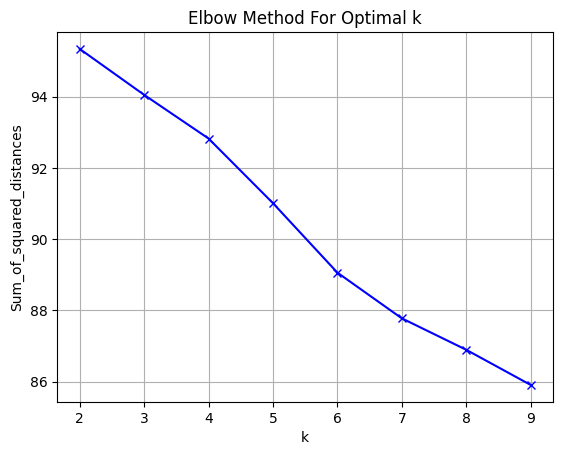

In [44]:
Sum_of_squared_distances = []
K = range(2,10)
for k in K:
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(x)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.grid()
plt.show()

In [ ]:
n_clusters = 20
model = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=200, n_init=10)
model.fit(x)
labels=model.labels_

labels

df['labels']=pd.Series(labels, dtype=int)

In [47]:
df[df['labels']==3]

,url,text,photo_url,date,text_clean,len,text_lemma,text_lemma_cleaned,labels
0,https://t.me/boris_rozhin,🇷🇺🇺🇦 259-й день спецоперации ВС РФ отметился п...,NaN,2022-11-10T00:04:40,🇷🇺🇺🇦 259-й день спецоперации вс рф отметился п...,297,"['🇷', '🇺', '🇺', '🇦', '259-й', 'день', 'спецопе...","[259-й, спецоперация, отметиться, отвод, росси...",3.0
13,https://t.me/boris_rozhin,Еще минус один бронеавтомобиль HMMWV вместе с ...,NaN,2022-11-10T12:01:34,еще минус один бронеавтомобиль hmmwv вместе с ...,70,"['еще', 'минус', 'один', 'бронеавтомобиль', 'h...","[минус, бронеавтомобиль, hmmwv, вместе, иностр...",3.0
38,https://t.me/boris_rozhin,Фортификационные работы на левом берегу Днепра...,NaN,2022-11-10T19:26:21,фортификационные работы на левом берегу днепра...,76,"['фортификационный', 'работа', 'на', 'левый', ...","[фортификационный, работа, левый, берег, днепр...",3.0
50,https://t.me/boris_rozhin,Согласно данным ООН с начала СВО за счет украи...,NaN,2022-11-10T23:29:43,согласно данным оон с начала сво за счет украи...,114,"['согласно', 'данным', 'оон', 'с', 'начало', '...","[согласно, данным, начало, украинских, беженец...",3.0


In [58]:
# df = df.drop([94, ])
df[df['labels']==11]


,url,text,photo_url,date,text_clean,len,text_lemma,text_lemma_cleaned,labels
32,https://t.me/boris_rozhin,"Праворульный Toyota Mega Cruiser, который стои...",NaN,2022-11-10T18:07:24,"праворульный toyota mega cruiser, который стои...",212,"['праворульный', 'toyota', 'mega', 'cruiser', ...","[праворульный, toyota, cruiser, который, стоит...",11.0
40,https://t.me/boris_rozhin,Еще один уничтоженный украинский танк Т-64БВ г...,NaN,2022-11-10T20:16:46,еще один уничтоженный украинский танк т-64бв г...,85,"['еще', 'один', 'уничтожить', 'украинский', 'т...","[уничтожить, украинский, т-64бв, проведение, у...",11.0
69,https://t.me/boris_rozhin,"Комментарий Байдена на тему ""договорняков по У...",NaN,2022-11-11T08:50:08,"комментарий байдена на тему ""договорняков по у...",54,"['комментарий', 'байдена', 'на', 'тема', '""', ...","[комментарий, байдена, договорняков, украина]",11.0
83,https://t.me/boris_rozhin,Кремль по поводу оставления Херсона.\n\n1. Хер...,NaN,2022-11-11T12:21:13,кремль по поводу оставления херсона. 1. херсон...,357,"['кремль', 'по', 'повод', 'оставление', 'херсо...","[кремль, повод, оставление, херсон, херсонский...",11.0
95,https://t.me/boris_rozhin,С украинской стороны сообщают про новый обмен ...,NaN,2022-11-11T16:13:22,с украинской стороны сообщают про новый обмен ...,204,"['с', 'украинской', 'сторона', 'сообщать', 'пр...","[украинской, сторона, сообщать, новый, обмен, ...",11.0
